In [96]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
import torchinfo
import sklearn

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


Using device cpu


In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

In [3]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [4]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [5]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [ ]:
# _ = eval_model(data_loader)

In [ ]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

In [8]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
# for i in range(1,17,5):
#     show_prediction(exmp_batch[i], label_batch[i], preds[i])

In [ ]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

In [10]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))
    
# for i in range(1,17,5):
#     show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

In [24]:
adv_imgs[0].shape

torch.Size([3, 224, 224])

In [ ]:
# _ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])

In [13]:
import os
import torch
from torchvision.utils import save_image

def save_adversarial_images(adv_examples, labels, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create tensors for mean and std, ensuring they are on the same device as the images
    mean = torch.tensor(NORM_MEAN, device=device).view(3, 1, 1)
    std = torch.tensor(NORM_STD, device=device).view(3, 1, 1)

    for i, (adv_img, label) in enumerate(zip(adv_examples, labels)):
        # Create a subdirectory for the class label
        class_dir = os.path.join(output_dir, str(label.item()))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        # 1. Denormalize the image
        denorm_img = adv_img * std + mean
        
        # 2. Clip the image values to be in the valid [0, 1] range
        clipped_img = torch.clamp(denorm_img, 0, 1)
        
        # 3. Save the corrected, displayable image
        img_path = os.path.join(class_dir, f'adv_image_{i:04d}.png')
        save_image(clipped_img, img_path)

In [ ]:
# Generate adversarial examples for the entire dataset using FGSM and store them in a list
ADV_EXAMPLES_DIR = "../adversarial_examples"
if not os.path.exists(ADV_EXAMPLES_DIR):
    adv_examples = []
    labels_list = []
    pretrained_model.eval()  # Ensure model is in eval mode

    for imgs, labels in tqdm(data_loader, desc="Generating adversarial examples..."):
        adv_imgs, _ = fast_gradient_sign_method(pretrained_model, imgs, labels, epsilon=0.02)
        adv_examples.extend(adv_imgs.cpu())
        labels_list.extend(labels.cpu())

    # Save adversarial examples
    save_adversarial_images(adv_examples, labels_list, ADV_EXAMPLES_DIR)
    adv_examples = torchvision.datasets.ImageFolder(ADV_EXAMPLES_DIR, transform= plain_transforms)

else:
    adv_examples = torchvision.datasets.ImageFolder(ADV_EXAMPLES_DIR, transform= plain_transforms)

In [38]:
adv_dataloader = data.DataLoader(adv_examples, batch_size=32, shuffle=False, drop_last=False, num_workers=8)
exmp_adv_batch, label = next(iter(adv_dataloader))
with torch.no_grad():
    preds_adv = pretrained_model(exmp_adv_batch.to(device))

In [40]:
adv_examples

Dataset ImageFolder
    Number of datapoints: 5000
    Root location: ../adversarial_examples
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

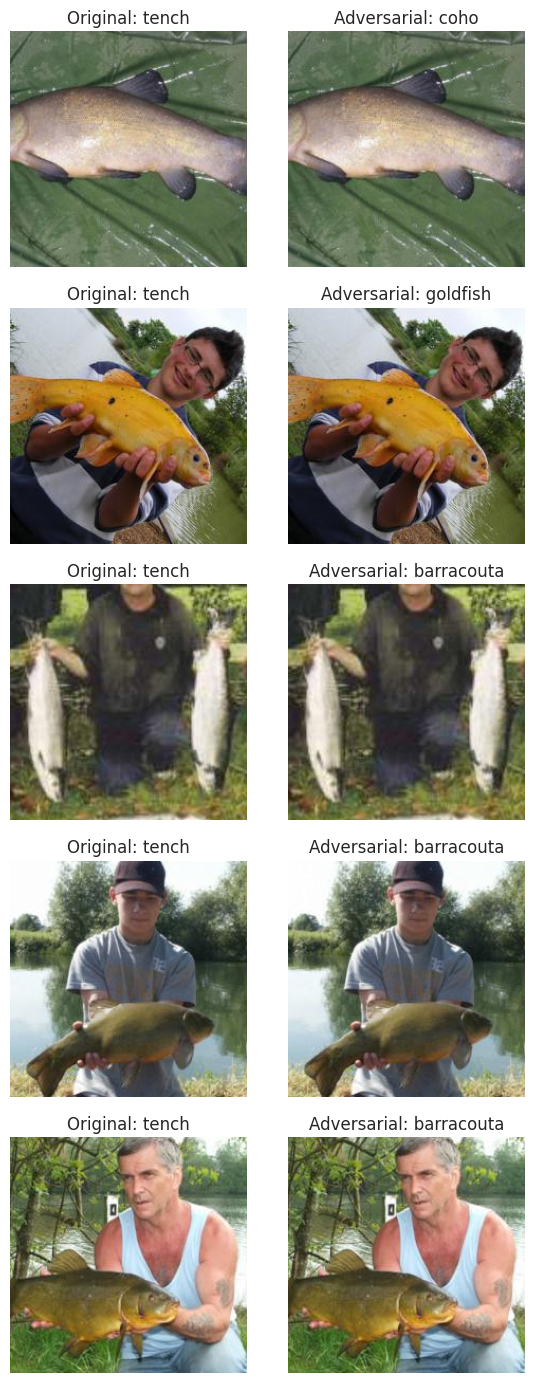

In [41]:
# Plot the first 5 original and adversarial images side by side

fig, axes = plt.subplots(5, 2, figsize=(6, 14))
for i in range(5):
    # Original image
    img = exmp_batch[i].cpu().permute(1, 2, 0).numpy()
    img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None]
    img = np.clip(img, 0, 1)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original: {label_names[label_batch[i]]}")
    axes[i, 0].axis('off')
    
    # Adversarial image (display)
    adv_img_disp = exmp_adv_batch[i].cpu().permute(1, 2, 0).numpy()
    adv_img_disp = (adv_img_disp * NORM_STD[None, None]) + NORM_MEAN[None, None]
    adv_img_disp = np.clip(adv_img_disp, 0, 1)
    axes[i, 1].imshow(adv_img_disp)

    # Get model prediction for this adversarial image and use it in the title
    with torch.no_grad():
        inp = exmp_adv_batch[i].unsqueeze(0).to(device)  # shape (1,3,224,224)
        preds = pretrained_model(inp)
        pred_idx = preds.argmax(dim=-1).item()
    axes[i, 1].set_title(f"Adversarial: {label_names[pred_idx]}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [42]:
# Get your batch from the adv_loader
exmp_adv_batch, _ = next(iter(adv_dataloader))
print(f"Tensor range after loading: Min={exmp_adv_batch.min():.2f}, Max={exmp_adv_batch.max():.2f}")

Tensor range after loading: Min=-2.12, Max=2.64


In [43]:
exmp_batch, _ = next(iter(data_loader))
print(f"Tensor range after loading: Min={exmp_batch.min():.2f}, Max={exmp_batch.max():.2f}")

Tensor range after loading: Min=-2.12, Max=2.64


# Hooks to get activations

In [44]:
torchinfo.summary(pretrained_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

In [45]:
layers_to_probe = {
    'layer1': pretrained_model.layer1,
    'layer2': pretrained_model.layer2,
    'layer3': pretrained_model.layer3,
    'layer4': pretrained_model.layer4,
}
activations = {}

def get_activation(name):
    """Creates a hook function to capture the output of a layer."""
    def hook(model, input, output):
        # Detach from the computation graph and move to CPU
        # Average over spatial dimensions (-1, -2) if output is 4D (batch, channels, H, W)
        if output.dim() == 4:
            activations[name] = output.detach().cpu().mean(dim=(-1, -2))
        else:
            activations[name] = output.detach().cpu()
    return hook

# Register a forward hook for each layer we want to probe
for name, layer in layers_to_probe.items():
    layer.register_forward_hook(get_activation(name))

In [65]:
# Run inference on a batch of normal images and collect activations
# exmp_batch, label_batch = next(iter(data_loader))
activations_total = {}
for exmp_batch, _ in tqdm(data_loader):
    activations = {}
    with torch.no_grad():
        _ = pretrained_model(exmp_batch.to(device))
    for name, module in layers_to_probe.items():
        if name in activations_total:
            activations_total[name] = torch.cat((activations_total[name], activations[name]), dim=0)
        else:
            activations_total[name] = activations[name]

# The activations dictionary now contains outputs for each probed layer
# for layer_name, act in activations_total.items():
#     print(f"{layer_name}: shape={act.shape}")

100%|██████████| 157/157 [01:45<00:00,  1.49it/s]


In [70]:
#save activations_total dictionary
torch.save(activations_total, "activations_total.pth")

In [ ]:
normal_activations = torch.load("activations_total.pth")

In [76]:
for layer_name, act in normal_activations.items():
    print(f"{layer_name}: shape={act.shape}")

layer1: shape=torch.Size([5000, 64])
layer2: shape=torch.Size([5000, 128])
layer3: shape=torch.Size([5000, 256])
layer4: shape=torch.Size([5000, 512])


In [77]:
adv_activ_total = {}
for exmp_batch, _ in tqdm(adv_dataloader):
    activations = {}
    with torch.no_grad():
        _ = pretrained_model(exmp_batch.to(device))
    for name, module in layers_to_probe.items():
        if name in adv_activ_total:
            adv_activ_total[name] = torch.cat((adv_activ_total[name], activations[name]), dim=0)
        else:
            adv_activ_total[name] = activations[name]

100%|██████████| 157/157 [01:51<00:00,  1.41it/s]


In [78]:
torch.save(adv_activ_total, "adv_activ_total.pth")

In [79]:
adv_activ_total = torch.load("adv_activ_total.pth")

In [97]:
from sklearn.model_selection import train_test_split

# Get the number of samples (assume all layers have the same number of samples)
num_samples = next(iter(normal_activations.values())).shape[0]
indices = np.arange(num_samples)

# Split indices for train/test (same split for all layers)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

# Create train/test splits for each layer
normal_train = {layer: acts[train_idx] for layer, acts in normal_activations.items()}
normal_test = {layer: acts[test_idx] for layer, acts in normal_activations.items()}
adv_train = {layer: acts[train_idx] for layer, acts in adv_activ_total.items()}
adv_test = {layer: acts[test_idx] for layer, acts in adv_activ_total.items()}

In [102]:
from torch.utils.data import TensorDataset

probe_datasets = {}

for layer in normal_activations.keys():
    # Get activations for normal and adversarial samples (train and test splits)
    normal_train_acts = normal_train[layer]
    adv_train_acts = adv_train[layer]
    normal_test_acts = normal_test[layer]
    adv_test_acts = adv_test[layer]

    # Concatenate activations for train and test
    X_train = torch.cat([normal_train_acts, adv_train_acts], dim=0)
    y_train = torch.cat([
        torch.zeros(normal_train_acts.shape[0], dtype=torch.long),
        torch.ones(adv_train_acts.shape[0], dtype=torch.long)
    ], dim=0)

    X_test = torch.cat([normal_test_acts, adv_test_acts], dim=0)
    y_test = torch.cat([
        torch.zeros(normal_test_acts.shape[0], dtype=torch.long),
        torch.ones(adv_test_acts.shape[0], dtype=torch.long)
    ], dim=0)

    # Store as tuple of TensorDatasets for train and test
    probe_datasets[layer] = {
        'train': TensorDataset(X_train, y_train),
        'test': TensorDataset(X_test, y_test)
    }

In [103]:
probe_datasets

{'layer1': {'train': <torch.utils.data.dataset.TensorDataset at 0x7f14f5492ba0>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7f14f57ae480>},
 'layer2': {'train': <torch.utils.data.dataset.TensorDataset at 0x7f14f57ae7e0>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7f14f57afcb0>},
 'layer3': {'train': <torch.utils.data.dataset.TensorDataset at 0x7f14f532f8f0>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7f15459e0b30>},
 'layer4': {'train': <torch.utils.data.dataset.TensorDataset at 0x7f14f58e2390>,
  'test': <torch.utils.data.dataset.TensorDataset at 0x7f14f58e0650>}}

In [87]:
# Define linear probes for each layer with the corresponding input sizes
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.linear(x)

probe_input_dims = {
    'layer1': 64,
    'layer2': 128,
    'layer3': 256,
    'layer4': 512,
}

linear_probes = {
    layer: LinearProbe(input_dim)
    for layer, input_dim in probe_input_dims.items()
}

In [105]:
from torch.utils.data import DataLoader

# Prepare dataloaders for layer1 probe
batch_size = 128
train_loader = DataLoader(probe_datasets['layer1']['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(probe_datasets['layer1']['test'], batch_size=batch_size, shuffle=False)

# Get the linear probe for layer1
probe = linear_probes['layer1'].to(device)

# Optimizer and loss
optimizer = optim.Adam(probe.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [106]:
num_epochs = 10
probe.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = probe(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    avg_loss = total_loss / total
    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")

Epoch 1/10 - Loss: 0.6972 - Accuracy: 0.5102
Epoch 2/10 - Loss: 0.6910 - Accuracy: 0.5246
Epoch 3/10 - Loss: 0.6890 - Accuracy: 0.5425
Epoch 4/10 - Loss: 0.6867 - Accuracy: 0.5713
Epoch 5/10 - Loss: 0.6847 - Accuracy: 0.5727
Epoch 6/10 - Loss: 0.6838 - Accuracy: 0.5654
Epoch 7/10 - Loss: 0.6813 - Accuracy: 0.5876
Epoch 8/10 - Loss: 0.6795 - Accuracy: 0.6011
Epoch 9/10 - Loss: 0.6778 - Accuracy: 0.6036
Epoch 10/10 - Loss: 0.6771 - Accuracy: 0.5979


In [111]:
# Train a linear probe for each layer and store results
probe_results = {}

num_epochs = 20
for layer, probe in linear_probes.items():
    print(f"\nTraining probe for {layer}...")
    probe = probe.to(device)
    optimizer = optim.Adam(probe.parameters(), lr=1e-2)
    criterion = nn.CrossEntropyLoss()
    train_loader = torch.utils.data.DataLoader(probe_datasets[layer]['train'], batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(probe_datasets[layer]['test'], batch_size=128, shuffle=False)

    # Training loop
    for epoch in range(num_epochs):
        probe.train()
        total_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = probe(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = total_loss / total
        acc = correct / total
        print(f"  Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")

    # Evaluate on test set
    probe.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = probe(X_batch)
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    test_acc = correct / total
    print(f"Test accuracy for {layer}: {test_acc:.4f}")
    probe_results[layer] = test_acc
    # Save the trained probe for this layer
    torch.save(probe.state_dict(), f"{layer}_linear_probe.pth")


Training probe for layer1...
  Epoch 1/20 - Loss: 0.5919 - Accuracy: 0.7115
  Epoch 2/20 - Loss: 0.5895 - Accuracy: 0.7139
  Epoch 3/20 - Loss: 0.5892 - Accuracy: 0.7134
  Epoch 4/20 - Loss: 0.5898 - Accuracy: 0.7136
  Epoch 5/20 - Loss: 0.5854 - Accuracy: 0.7174
  Epoch 6/20 - Loss: 0.5850 - Accuracy: 0.7209
  Epoch 7/20 - Loss: 0.5865 - Accuracy: 0.7106
  Epoch 8/20 - Loss: 0.5832 - Accuracy: 0.7186
  Epoch 9/20 - Loss: 0.5804 - Accuracy: 0.7198
  Epoch 10/20 - Loss: 0.5799 - Accuracy: 0.7248
  Epoch 11/20 - Loss: 0.5777 - Accuracy: 0.7224
  Epoch 12/20 - Loss: 0.5775 - Accuracy: 0.7220
  Epoch 13/20 - Loss: 0.5769 - Accuracy: 0.7212
  Epoch 14/20 - Loss: 0.5742 - Accuracy: 0.7269
  Epoch 15/20 - Loss: 0.5738 - Accuracy: 0.7249
  Epoch 16/20 - Loss: 0.5772 - Accuracy: 0.7175
  Epoch 17/20 - Loss: 0.5764 - Accuracy: 0.7208
  Epoch 18/20 - Loss: 0.5733 - Accuracy: 0.7242
  Epoch 19/20 - Loss: 0.5698 - Accuracy: 0.7300
  Epoch 20/20 - Loss: 0.5756 - Accuracy: 0.7166
Test accuracy for l

In [118]:
probe_results

{'layer1': 0.7255, 'layer2': 0.7845, 'layer3': 0.747, 'layer4': 0.6205}

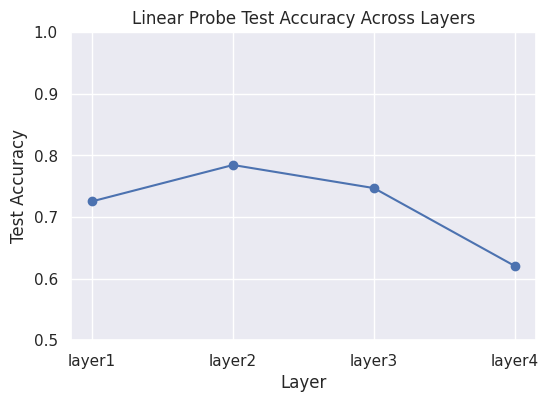

In [117]:
# Plot probe test accuracy across layers
layer_names = list(probe_results.keys())
accuracies = [probe_results[layer] for layer in layer_names]

plt.figure(figsize=(6, 4))
plt.plot(layer_names, accuracies, marker='o')
plt.ylabel('Test Accuracy')
plt.xlabel('Layer')
plt.title('Linear Probe Test Accuracy Across Layers')
plt.ylim(0.5, 1)
plt.show()